In [29]:
import parflow as pf
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
import config
import shutil

In [30]:
num_timesteps = 8760
read_interval = 24

runs_folder = "./domains/outputs"
run_dir = runs_folder + f"/{config.CURRENT_RUN_NAME}_{config.CURRENT_START_YEAR}_to_{config.CURRENT_END_YEAR}_conus2"
run_name = f"{config.CURRENT_RUN_NAME}_{config.CURRENT_START_YEAR}_to_{config.CURRENT_END_YEAR}"
data_accessor = pf.Run.from_definition(f'{run_dir}/{run_name}.pfidb').data_accessor
shutil.copyfile(f'{run_dir}/mannings.pfb', f'{run_dir}/{run_name}.out.mannings.pfb')

run_def = {}
run_def["mask"] = np.where(data_accessor.mask > 0, 1, np.nan)
run_def["porosity"] = data_accessor.computed_porosity
run_def["dx"] = data_accessor.dx
run_def["dy"] = data_accessor.dy
run_def["dz"] = data_accessor.dz
run_def["specific_storage"] = data_accessor.specific_storage
mask = pf.read_pfb(run_dir + "/mask.pfb")


Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


/opt/homebrew/anaconda3/envs/test-env/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [31]:
def load_pfb(variable, time, dump_interval=1):
    timestamp = f"{int(time/dump_interval)}".rjust(5, "0")
    return pf.read_pfb(run_dir + f"/{run_name}.out.{variable}.{timestamp}.pfb")

In [32]:
def load_variable(loading_function, time, data_accessor):
    data_accessor.time = time
    return loading_function(data_accessor)

In [33]:

data = pd.DataFrame()
data["time"] = np.arange(0, num_timesteps, read_interval)
data["pressure"] = np.array(load_variable(lambda x: data_accessor.pressure, time, data_accessor)*run_def["mask"] for time in data.time)

data["OutletFlow"] = np.array(load_variable(lambda x: data_accessor.overland_flow(), time, data_accessor) for time in data.time)
data["saturation"] = np.array(load_variable(lambda x: data_accessor.pressure, time, data_accessor)*run_def["mask"] for time in data.time)
data["subsurface_storage"] = np.array(load_variable(lambda x: data_accessor.subsurface_storage, time, data_accessor)*run_def["mask"] for time in data.time)
data["surface_storage"] = np.array(load_variable(lambda x: data_accessor.surface_storage, time, data_accessor)*run_def["mask"][0] for time in data.time)
data["wtd"] = np.array(load_variable(lambda x: data_accessor.wtd, time, data_accessor)*run_def["mask"][0] for time in data.time)
data["total_storage"] = data["subsurface_storage"].apply(np.nansum) + data["surface_storage"].apply(np.nansum)
data["water required to recover"] = data["total_storage"][0]-data["total_storage"]

In [34]:
data.surface_storage[0].sum()

nan

In [35]:
px.imshow(
    data["surface_storage"][200]-data["surface_storage"][0],
    color_continuous_scale=px.colors.diverging.BrBG,
    color_continuous_midpoint=0,
    title="Surface Storage Change over one year of drought"
    )

In [36]:
px.imshow(
    data["wtd"][1] - data["wtd"][200],
    color_continuous_scale=px.colors.diverging.BrBG,
    color_continuous_midpoint=0,
    title="Change in water table depth over one year of drought"
    )

In [37]:
px.line(data["water required to recover"], title="Water required to recover over one year of drought")

In [43]:
px.line(data["OutletFlow"]/(60*24), title="Simulation Streamflow")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   datetime          732 non-null    datetime64[ns, UTC]
 1   site_no           732 non-null    object             
 2   00060_Mean        732 non-null    float64            
 3   00060_Mean_cd     732 non-null    object             
 4   00065_Maximum     727 non-null    float64            
 5   00065_Maximum_cd  727 non-null    object             
 6   00065_Minimum     727 non-null    float64            
 7   00065_Minimum_cd  727 non-null    object             
 8   00065_Mean        727 non-null    float64            
 9   00065_Mean_cd     727 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), object(5)
memory usage: 57.3+ KB


<Axes: title={'center': 'Reference Gage Data'}, xlabel='datetime'>

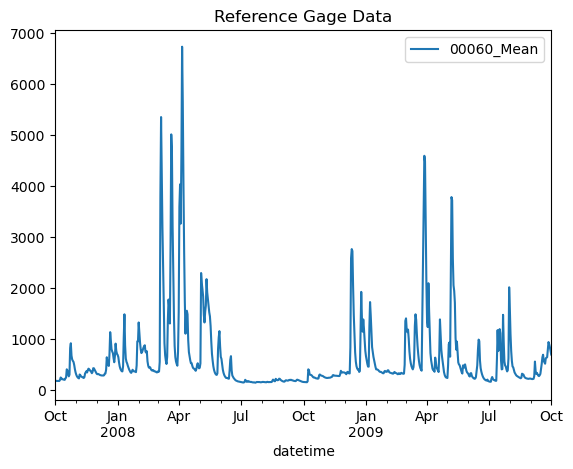

In [41]:
# compare to reference gage data
import dataretrieval.nwis as nwis

# specify the USGS site code for which we want data.
site = config.CURRENT_REFERENCE_GAGE
# get daily values (dv)
reference_data = nwis.get_record(sites=site, service='dv', start=config.CURRENT_START_DATE, end=config.CURRENT_END_DATE)
reference_data = reference_data.reset_index()
reference_data.info()
reference_data.plot(x='datetime', y='00060_Mean', title='Reference Gage Data')

In [40]:
import numpy
numpy.version.version

'1.23.5'